## Filter performances


In [10]:
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt

from experiment_config import DATA_NAME

In [11]:
data_split = "test" # "dev" #


experiment_dir = Path('experiments')/DATA_NAME

## Import training data


In [12]:
df_hi = pd.read_csv(experiment_dir/f'hidata_{data_split}.csv')
units = df_hi['unit'].astype(int).unique().tolist()
units 

[7, 8, 9, 10]

In [13]:
df_hi

,unit,cycle,T48,SmLPC,SmHPC,hs
0,7.0,1.0,0.987854,0.960245,0.996435,1.0
1,7.0,2.0,0.994195,0.927399,0.853594,1.0
2,7.0,3.0,0.971259,1.000000,0.935343,1.0
3,7.0,4.0,0.992060,0.925391,0.851702,1.0
4,7.0,5.0,0.971830,0.939829,0.960128,1.0
...,...,...,...,...,...,...
336,10.0,78.0,0.204769,0.119448,0.320313,0.0
337,10.0,79.0,0.154906,0.051598,0.254819,0.0
338,10.0,80.0,0.128198,0.145876,0.138560,0.0
339,10.0,81.0,0.070870,0.138470,0.027300,0.0


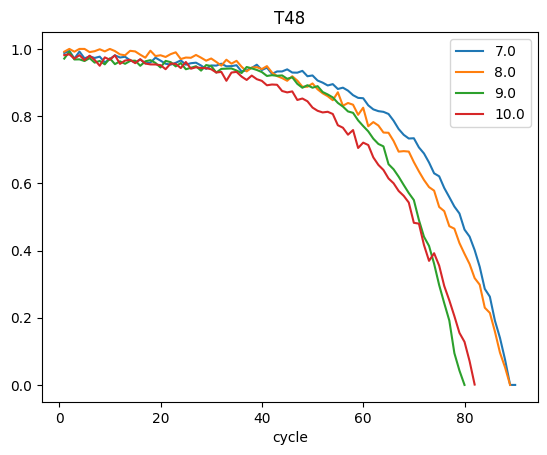

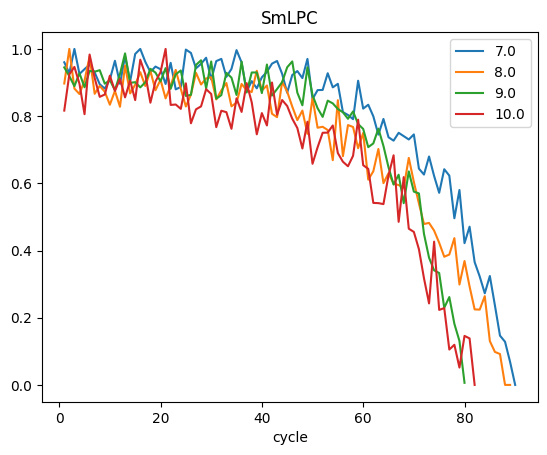

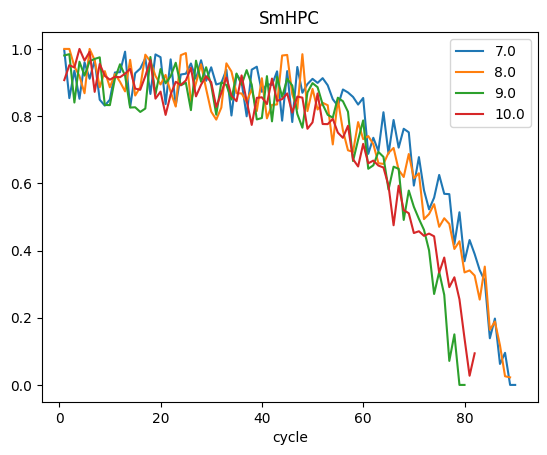

In [14]:
perform_names = [col for col in df_hi.columns if col not in ['unit', 'cycle','hs']]
for name in perform_names:
    fig, ax = plt.subplots()
    ax.title.set_text(name)
    df_hi.set_index("cycle").groupby("unit")[name].plot(legend=True) 
    

In [15]:
class AdaptiveEMA:
    def __init__(self, beta=0.05, k=10.0):
        self.beta = beta      # noise memory
        self.k = k            # smoothing strength
        self.y = None
        self.var = 0.0

    def step(self, x):
        if self.y is None:
            self.y = x
            return x

        # innovation
        e = x - self.y

        # update noise estimate (EW variance)
        self.var = self.beta * (e ** 2) + (1 - self.beta) * self.var
        sigma = self.var ** 0.5

        # adaptive smoothing
        alpha = 1.0 / (1.0 + self.k * sigma)

        # update filtered signal
        self.y = alpha * x + (1 - alpha) * self.y

        return self.y

In [16]:
noise_memory = 0.01
smoothing_strength = 20.0
for name in perform_names:
	for unit, idx in df_hi.groupby("unit").groups.items():
		f = AdaptiveEMA(beta=noise_memory, k=smoothing_strength)
		df_hi.loc[idx, name] = [
			f.step(x) for x in df_hi.loc[idx, name].values
		]

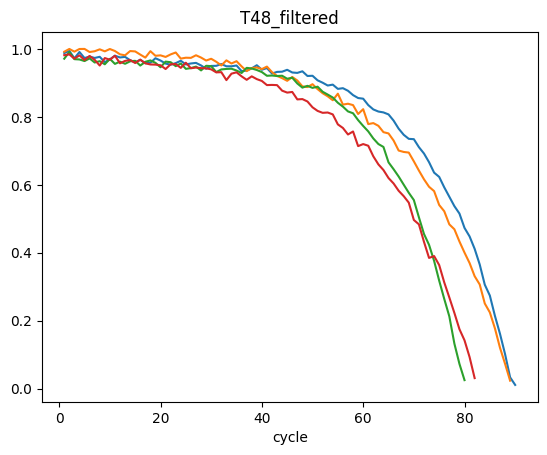

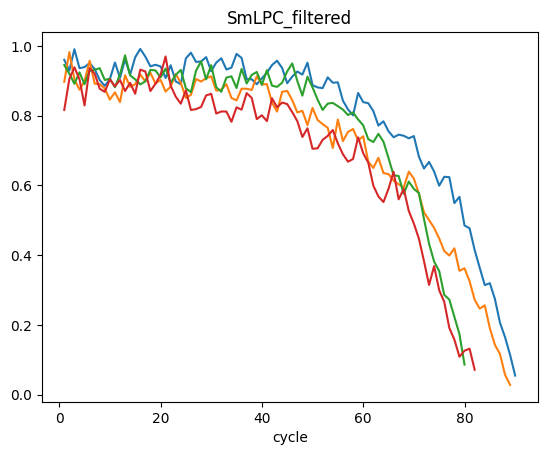

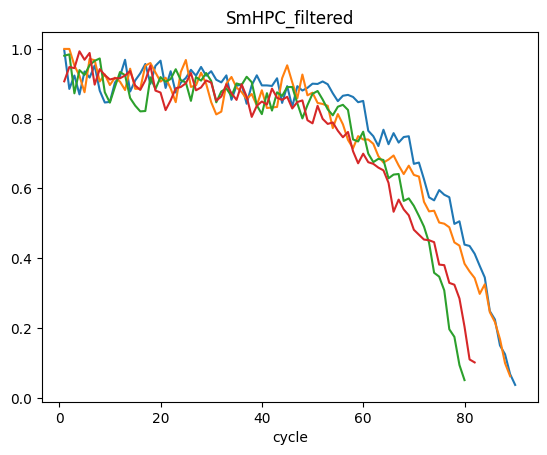

In [17]:
for name in perform_names:
    fig, ax = plt.subplots()
    ax.title.set_text(f"{name}_filtered")
    df_hi.set_index("cycle").groupby("unit")[name].plot(legend=False)
    plt.show()

## Save filtered hi data

In [18]:
df_hi.to_csv(experiment_dir/f'hidata_{data_split}_filtered.csv', index=False)